In [1]:
%matplotlib inline
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data
from SALib.sample import latin, saltelli, fast_sampler
from SALib.sample.morris import sample
from SALib.analyze import sobol, fast, morris
from functions.stylizedfacts import *
from functions.evolutionaryalgo import *
from functions.sensitivity_analysis import *
from functions.helpers import hurst, organise_data
import matplotlib.pyplot as plt
from matplotlib import style
import quandl

In [2]:
style.use('ggplot')

# Sensitivity analysis with respect to expectation components
Perform sensitivity analyis on stylized facts with respect to the four components of expectations.

## 2 Define parameter space bounds 

Table 1 shows the parameter bounds, uncertain parameters are **bold**. 

| Parameter | Values (start, stop, step) |
| -------------| ------------|
| ticks       | 1000   |
| fundamental_value       | 166    |
| std_fundamental       | 0.053    |
| spread_max       | 0.0004      |
| **trader_sample_size**      | 1, 100, 10      |
| **std_noise**       | 0.01, 0.35, 0.01      |
| **std_vol**       | 1, 50, 1      |
| **w_fundamentalists**       | 0.0, 100.0., 1.0      |
| **w_momentum**       | 0.0, 100.0, 1.0      |
| **w_random**       | 0.0, 100.0, 1.0      |
| **w_mean_reversion**       | 0.0, 100.0, 1.0       |
| **horizon_max**       | 9, 30, 1      |
| **n_traders**       | 50, 1550     |
| **max_order_expiration_ticks**       | 5, 100     |
*Table 1 Parameter bounds*

In [3]:
problem_morris = {
  'num_vars': 10,
  'names': ['trader_sample_size', 'std_noise', 
            'std_vol', 'w_fundamentalists', 'w_momentum',
           'w_random', 'w_mean_reversion',
           'horizon_max', 'n_traders', 'max_order_expiration_ticks'],
  'bounds': [[1, 30], [0.05, 0.30], 
             [1, 20], [0.0, 100.0], [0.0, 100.0], 
             [1.0, 100.0], [0.0, 100.0],
             [9, 30], [50, 1550], [5, 100]]
}

## Perform Morris methods sensitivity analyis

In [4]:
morris_params = sample(problem_morris, N=250, num_levels=4, grid_jump=2)
morris_parameter_list = morris_params.tolist()

In [5]:
# convert nescessary parameters to ints
for idx, parameters in enumerate(morris_parameter_list):
    # ints: 0, 2, 7
    morris_parameter_list[idx][0] = int(morris_parameter_list[idx][0])
    morris_parameter_list[idx][2] = int(morris_parameter_list[idx][2])
    morris_parameter_list[idx][7] = int(morris_parameter_list[idx][7])
    morris_parameter_list[idx][8] = int(morris_parameter_list[idx][8])
    morris_parameter_list[idx][9] = int(morris_parameter_list[idx][9])

In [6]:
all_morris_parameters = []
for parameters in morris_parameter_list:
    pars = {}
    for key, value in zip(problem_morris['names'], parameters):
        pars[key] = value
    all_morris_parameters.append(pars)

In [7]:
fixed_parameters = {"ticks": 1200, "fundamental_value": 166,
                    'std_fundamental': 0.053, 'spread_max': 0.004087}

In [9]:
# TODO check what is going wrong here 1 problem only fundamentalist and mean reversion traders
morris_output = simulate_params_sobol(NRUNS=1, parameter_set=all_morris_parameters, fixed_parameters=fixed_parameters)

In [10]:
first_order_autocors = np.array(morris_output[0])
autocors1 = np.array(morris_output[1])
autocors5 = np.array(morris_output[2])
mean_abs_autocor = np.array(morris_output[3])
kurtosis = np.array(morris_output[4])
spy_abs_auto10 = np.array(morris_output[5])
spy_abs_auto25 = np.array(morris_output[6])
spy_abs_auto50 = np.array(morris_output[7])
spy_abs_auto100 = np.array(morris_output[8])
cointegrations = np.array(morris_output[9])

In [11]:
# table 
spy_abs_auto100 = np.nan_to_num(spy_abs_auto100)

In [12]:
morris_auto_cors = morris.analyze(problem=problem_morris, X=morris_params, Y=first_order_autocors)
morris_autocors1 = morris.analyze(problem=problem_morris, X=morris_params, Y=autocors1)
morris_autocors5 = morris.analyze(problem=problem_morris, X=morris_params, Y=autocors5)
morris_mean_abs_autocor = morris.analyze(problem=problem_morris, X=morris_params, Y=mean_abs_autocor)
morris_kurtosis = morris.analyze(problem=problem_morris, X=morris_params, Y=kurtosis)
morris_spy_abs_auto10 = morris.analyze(problem=problem_morris, X=morris_params, Y=spy_abs_auto10)
morris_spy_abs_auto25 = morris.analyze(problem=problem_morris, X=morris_params, Y=spy_abs_auto25)
morris_spy_abs_auto50 = morris.analyze(problem=problem_morris, X=morris_params, Y=spy_abs_auto50)
morris_spy_abs_auto100 = morris.analyze(problem=problem_morris, X=morris_params, Y=spy_abs_auto100)
morris_cointegrations = morris.analyze(problem=problem_morris, X=morris_params, Y=cointegrations)

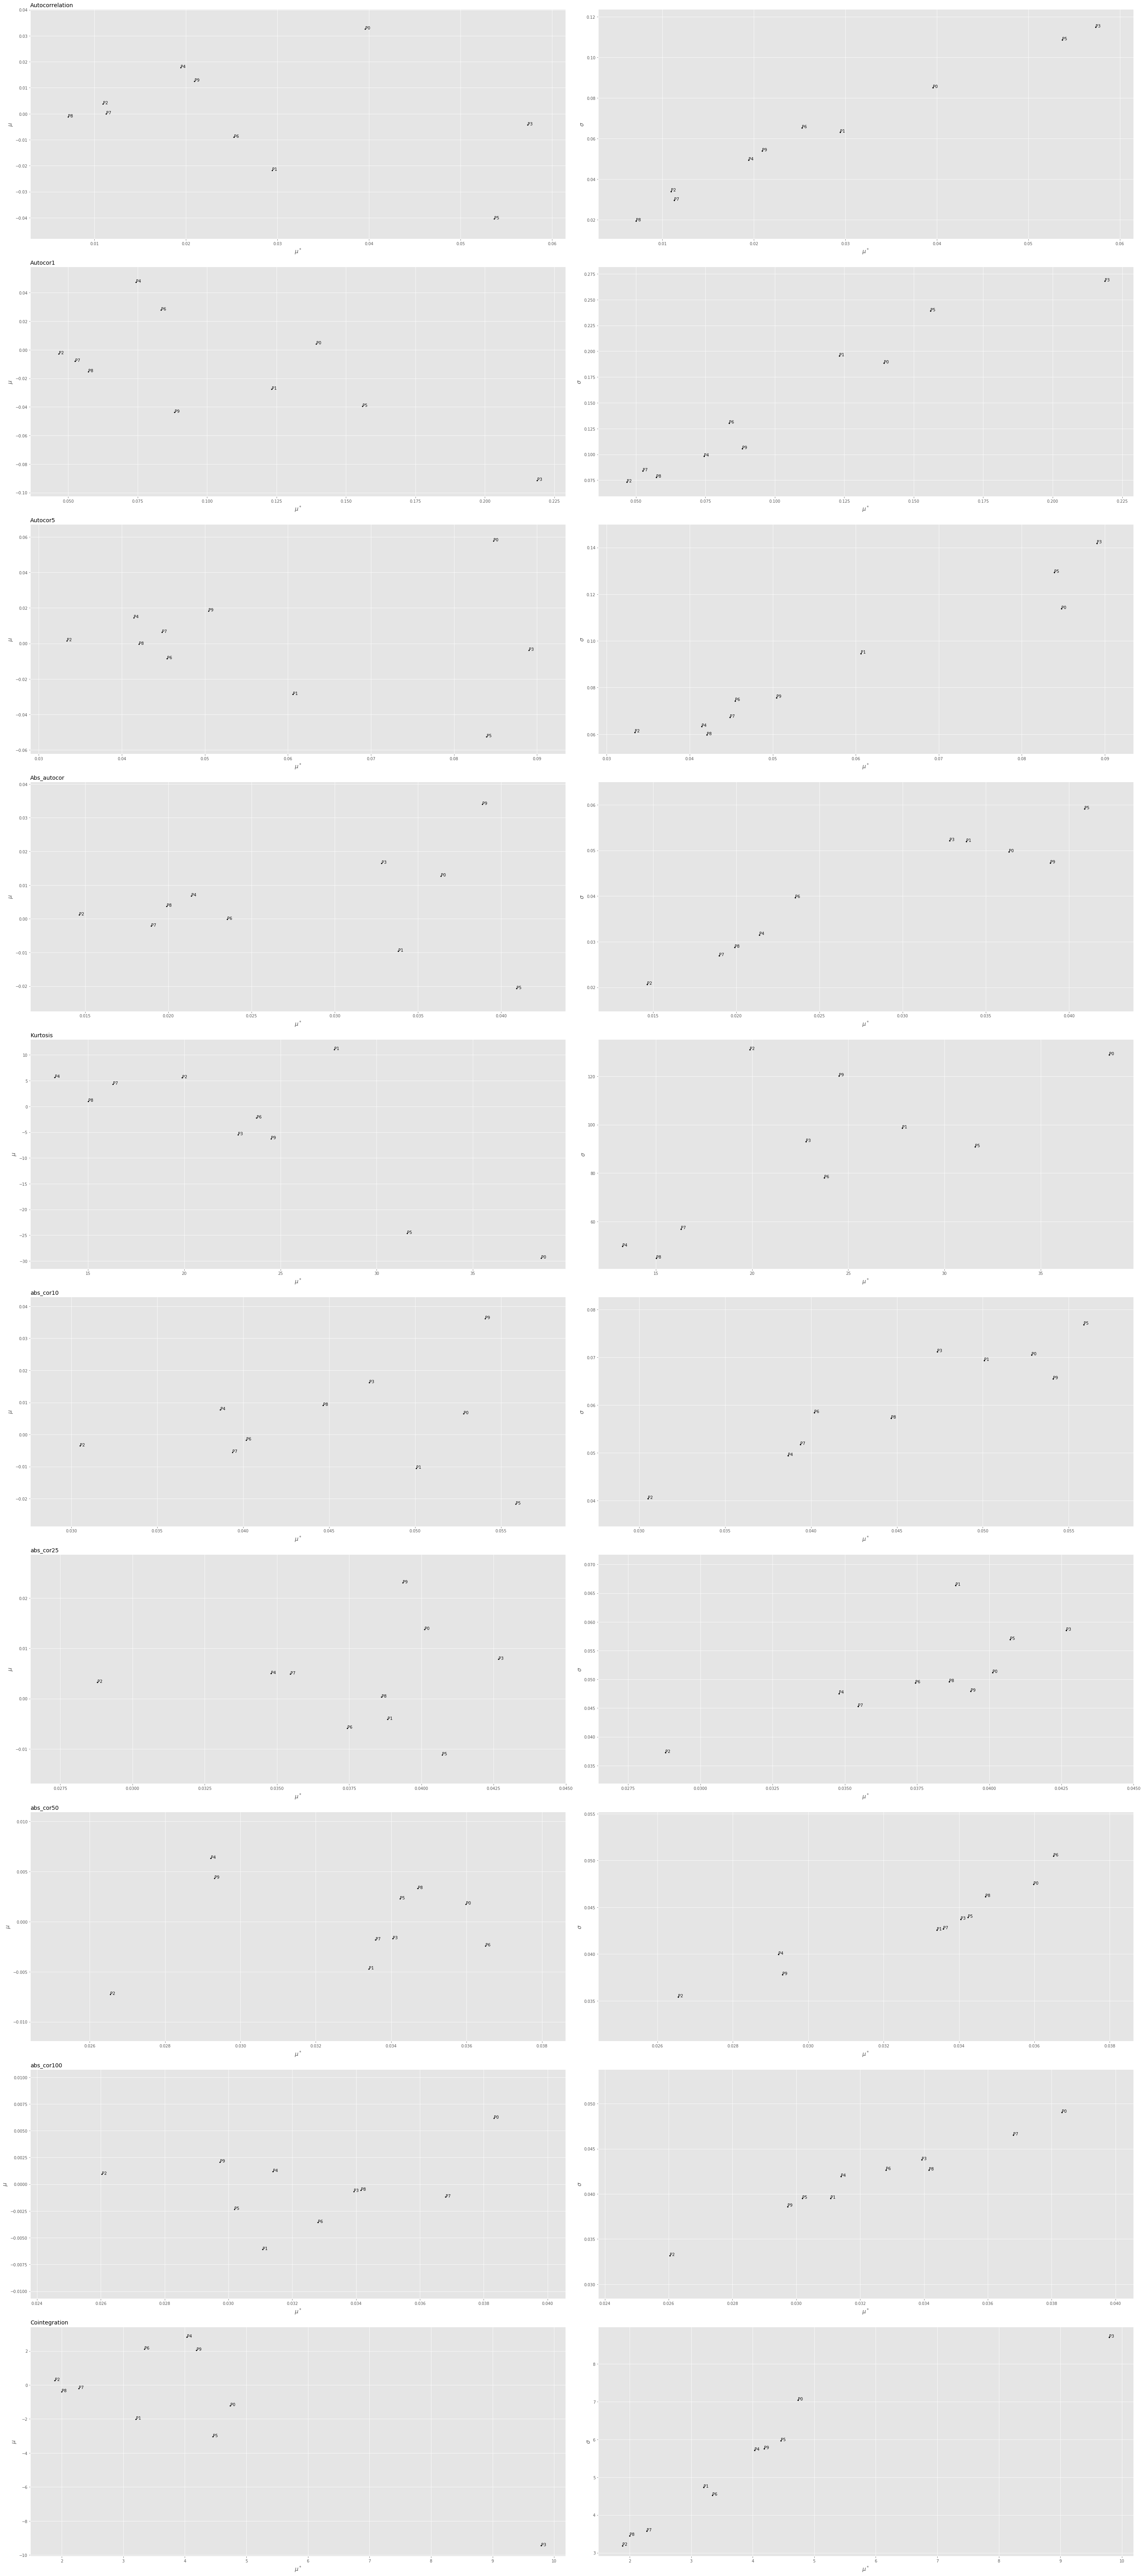

In [13]:
fig, ((ax1, ax2),(ax3, ax4),(ax5, ax6), (ax7, ax8),(ax9, ax10),
     (ax11, ax12), (ax13, ax14), (ax15, ax16), (ax17, ax18), (ax19, ax20)) = plt.subplots(10, 2, figsize=(40, 90))

axes = ((ax1, ax2),(ax3, ax4),(ax5, ax6), (ax7, ax8),(ax9, ax10),
        (ax11, ax12), (ax13, ax14), (ax15, ax16), (ax17, ax18), (ax19, ax20))
morris_tests = [morris_auto_cors, morris_autocors1, morris_autocors5, morris_mean_abs_autocor, 
                morris_kurtosis, morris_spy_abs_auto10, morris_spy_abs_auto25, 
                morris_spy_abs_auto50, morris_spy_abs_auto100, morris_cointegrations]
test_labels = ['Autocorrelation', 'Autocor1', 'Autocor5', 'Abs_autocor', 'Kurtosis',
              'abs_cor10', 'abs_cor25', 'abs_cor50', 'abs_cor100', 'Cointegration']

for idx, axis in enumerate(axes):
    Y1 = morris_tests[idx]['mu']
    Y2 = morris_tests[idx]['sigma']
    X = morris_tests[idx]['mu_star']
    labels = ['P{}'.format(n) for n in range(len(X))]

    axis[0].set_title(test_labels[idx], loc='left', size='14')
    axis[0].scatter(X,Y1, color='k', marker='.', edgecolor = '')
    axis[0].set_ylabel('$\mu$', size='14')
    axis[0].set_xlabel('$\mu^*$', size='14')
    
    axis[1].scatter(X,Y2, color='k', marker='.')
    axis[1].set_ylabel('$\sigma$', size='14')
    axis[1].set_xlabel('$\mu^*$', size='14')

    for i, labels in enumerate(labels):
        axis[0].annotate(labels, (X[i], Y1[i]))
        axis[1].annotate(labels, (X[i], Y2[i]))

plt.tight_layout()
fig.savefig('morris_results.png', dpi = 300)

In [14]:
morris_categories = ['mu_star', 'mu', 'sigma']
parameter_lables = ['P{}'.format(n) for n in range(len(morris_tests[0][morris_categories[0]]))]

In [15]:
# create matrix with 
matrix = []
# fill rows
for stylized_fact in morris_tests:
    row = []
    for parameter in range(len(parameter_lables)):
    # append first mu_star, then mu, then sigma
        for category in morris_categories:
            # add element
            row.append(round(stylized_fact[category][parameter], 3))
#             for element in stylized_fact[category]:
#                 row.append(round(element, 3)) 
    matrix.append(row)

In [16]:
matrix

[[0.04,
  0.033,
  0.085,
  0.029,
  -0.022,
  0.063,
  0.011,
  0.004,
  0.034,
  0.057,
  -0.004,
  0.115,
  0.019,
  0.018,
  0.049,
  0.054,
  -0.04,
  0.109,
  0.025,
  -0.009,
  0.065,
  0.011,
  -0.0,
  0.03,
  0.007,
  -0.001,
  0.019,
  0.021,
  0.012,
  0.054],
 [0.139,
  0.004,
  0.188,
  0.123,
  -0.028,
  0.196,
  0.047,
  -0.003,
  0.073,
  0.219,
  -0.092,
  0.268,
  0.074,
  0.047,
  0.098,
  0.156,
  -0.04,
  0.239,
  0.083,
  0.028,
  0.13,
  0.052,
  -0.008,
  0.084,
  0.057,
  -0.015,
  0.078,
  0.088,
  -0.044,
  0.106],
 [0.085,
  0.058,
  0.114,
  0.061,
  -0.029,
  0.095,
  0.033,
  0.001,
  0.061,
  0.089,
  -0.004,
  0.142,
  0.041,
  0.014,
  0.063,
  0.084,
  -0.053,
  0.129,
  0.045,
  -0.009,
  0.074,
  0.045,
  0.006,
  0.067,
  0.042,
  -0.0,
  0.06,
  0.05,
  0.018,
  0.076],
 [0.036,
  0.013,
  0.05,
  0.034,
  -0.01,
  0.052,
  0.015,
  0.001,
  0.021,
  0.033,
  0.016,
  0.052,
  0.021,
  0.007,
  0.032,
  0.041,
  -0.021,
  0.059,
  0.024,
  -0.0,
 

In [17]:
morris_tests[0]

{'mu': array([ 0.03254311, -0.02187967,  0.00370183, -0.00434603,  0.017698  ,
        -0.04048908, -0.00905126, -0.00011026, -0.00126674,  0.0124199 ]),
 'mu_star': array([ 0.03958538,  0.02942947,  0.0109251 ,  0.05735029,  0.01943458,
         0.05369244,  0.02523587,  0.01127459,  0.0071267 ,  0.02092751]),
 'mu_star_conf': [0.010304957964959912,
  0.0075371166774927893,
  0.0040158116758754938,
  0.012572153966718793,
  0.006178610210443301,
  0.013046165734969594,
  0.0076862218808633545,
  0.0034172157602274391,
  0.0021400398968490779,
  0.0064792551847658976],
 'names': ['trader_sample_size',
  'std_noise',
  'std_vol',
  'w_fundamentalists',
  'w_momentum',
  'w_random',
  'w_mean_reversion',
  'horizon_max',
  'n_traders',
  'max_order_expiration_ticks'],
 'sigma': array([ 0.08513352,  0.06312747,  0.03406997,  0.11494382,  0.0494305 ,
         0.10870698,  0.0653201 ,  0.02963064,  0.01941625,  0.05401406])}

In [18]:
# create multi-level df 
header = pd.MultiIndex.from_product([parameter_lables, morris_categories], names=['parameter','categories'])
#header = pd.MultiIndex.from_product([['location1','location2'], ['S1','S2','S3']], names=['loc','S'])

df = pd.DataFrame(matrix,
                  index=test_labels,
                  columns=header)

In [19]:
df = df.stack()

In [20]:
df.head()

parameter                      P0     P1     P2     P3     P4     P5     P6  \
                categories                                                    
Autocorrelation mu          0.033 -0.022  0.004 -0.004  0.018 -0.040 -0.009   
                mu_star     0.040  0.029  0.011  0.057  0.019  0.054  0.025   
                sigma       0.085  0.063  0.034  0.115  0.049  0.109  0.065   
Autocor1        mu          0.004 -0.028 -0.003 -0.092  0.047 -0.040  0.028   
                mu_star     0.139  0.123  0.047  0.219  0.074  0.156  0.083   

parameter                      P7     P8     P9  
                categories                       
Autocorrelation mu         -0.000 -0.001  0.012  
                mu_star     0.011  0.007  0.021  
                sigma       0.030  0.019  0.054  
Autocor1        mu         -0.008 -0.015 -0.044  
                mu_star     0.052  0.057  0.088

In [21]:
df.to_csv('morris_results.csv' ,sep='&')

In [22]:
df = pd.read_csv('morris_results.csv' ,sep='&').set_index(['Unnamed: 0', 'categories'])

In [23]:
def to_rank(row):
    """transform row to ranks"""
    seq = sorted(row, reverse=True)
    new_row = [seq.index(v) + 1 for v in row]
    return new_row

In [24]:
for i in range(len(df)):
    df.iloc[i] = to_rank(df.iloc[i])

In [25]:
df.to_csv('morris_ranks.csv', float_format='%.f',sep='&')

Parameter names and numbers

0. 'trader_sample_size', 
1. 'std_noise', 
2. 'std_vol',
3. 'w_fundamentalists',
4. 'w_momentum',
5. 'w_random', 
6. 'w_mean_reversion',
7. 'horizon_max', 
8. 'n_traders', 
9. 'max_order_expiration_ticks'

In [26]:
df

P0    P1    P2    P3    P4    P5   P6   P7  \
Unnamed: 0      categories                                                 
Autocorrelation mu           1.0   9.0   4.0   7.0   2.0  10.0  8.0  5.0   
                mu_star      3.0   4.0   8.0   1.0   7.0   2.0  5.0  8.0   
                sigma        3.0   5.0   8.0   1.0   7.0   2.0  4.0  9.0   
Autocor1        mu           3.0   7.0   4.0  10.0   1.0   8.0  2.0  5.0   
                mu_star      3.0   4.0  10.0   1.0   7.0   2.0  6.0  9.0   
                sigma        4.0   3.0  10.0   1.0   7.0   2.0  5.0  8.0   
Autocor5        mu           1.0   9.0   5.0   7.0   3.0  10.0  8.0  4.0   
                mu_star      2.0   4.0  10.0   1.0   9.0   3.0  6.0  6.0   
                sigma        3.0   4.0   9.0   1.0   8.0   2.0  6.0  7.0   
Abs_autocor     mu           3.0   9.0   6.0   2.0   4.0  10.0  7.0  8.0   
                mu_star      3.0   4.0  10.0   5.0   7.0   1.0  6.0  9.0   
                sigma        4.0   2.0  10.0   2.0   7.0   1.0  6.0  9.0   
Kurtosis        mu          10.0   1.0   3.0   7.0   2.0   9.0  6.0  4.0   
                mu_star      1.0   3.0   7.0   6.0  10.0   2.0  5.0  8.0   
                sigma        2.0   4.0   1.0   5.0   9.0   6.0  7.0  8.0   
abs_cor10       mu           5.0   9.0   7.0   2.0   4.0  10.0  6.0  8.0   
                mu_star      3.0   4.0  10.0   5.0   8.0   1.0  7.0  8.0   
                sigma        3.0   4.0  10.0   2.0   9.0   1.0  6.0  8.0   
abs_cor25       mu           2.0   8.0   6.0   3.0   4.0  10.0  9.0  4.0   
                mu_star      3.0   4.0  10.0   1.0   8.0   2.0  7.0  8.0   
                sigma        4.0   1.0  10.0   2.0   7.0   3.0  6.0  9.0   
abs_cor50       mu           4.0   9.0  10.0   6.0   1.0   4.0  6.0  6.0   
                mu_star      2.0   7.0  10.0   4.0   8.0   4.0  1.0  4.0   
                sigma        2.0   6.0  10.0   4.0   8.0   4.0  1.0  6.0   
abs_cor100      mu           1.0  10.0   3.0   5.0   3.0   8.0  9.0  5.0   
                mu_star      1.0   6.0  10.0   3.0   6.0   8.0  5.0  2.0   
                sigma        1.0   7.0  10.0   3.0   6.0   7.0  4.0  2.0   
Cointegration   mu           7.0   8.0   4.0  10.0   1.0   9.0  2.0  5.0   
                mu_star      2.0   7.0  10.0   1.0   5.0   3.0  6.0  8.0   
                sigma        2.0   6.0  10.0   1.0   5.0   3.0  7.0  8.0   

                              P8   P9  
Unnamed: 0      categories             
Autocorrelation mu           6.0  3.0  
                mu_star     10.0  6.0  
                sigma       10.0  6.0  
Autocor1        mu           6.0  9.0  
                mu_star      8.0  5.0  
                sigma        9.0  6.0  
Autocor5        mu           6.0  2.0  
                mu_star      8.0  5.0  
                sigma       10.0  5.0  
Abs_autocor     mu           5.0  1.0  
                mu_star      8.0  2.0  
                sigma        8.0  5.0  
Kurtosis        mu           5.0  8.0  
                mu_star      9.0  4.0  
                sigma       10.0  3.0  
abs_cor10       mu           3.0  1.0  
                mu_star      6.0  2.0  
                sigma        7.0  5.0  
abs_cor25       mu           7.0  1.0  
                mu_star      4.0  4.0  
                sigma        5.0  7.0  
abs_cor50       mu           3.0  2.0  
                mu_star      3.0  8.0  
                sigma        3.0  9.0  
abs_cor100      mu           5.0  2.0  
                mu_star      3.0  8.0  
                sigma        4.0  9.0  
Cointegration   mu           6.0  3.0  
                mu_star      9.0  4.0  
                sigma        9.0  4.0

Influence on autocorrelation components

**Top 3**
1. w_fundamentalists
2. w_random
3. trader_sample_size

In [38]:
df.xs('mu_star', level='categories').loc[['Autocorrelation','Autocor1', 'Autocor5']].sum().sort_values()

P3     3.0
P5     7.0
P0     8.0
P1    12.0
P9    16.0
P6    17.0
P4    23.0
P7    23.0
P8    26.0
P2    28.0
dtype: float64

Influence on volatility clustering components: 

**Top 3**
1. w_random
2. max_order_expiration_ticks
3. trader_sample_size

In [37]:
df.xs('mu_star', level='categories').loc[['Abs_autocor']].sum().sort_values()

P5     1.0
P9     2.0
P0     3.0
P1     4.0
P3     5.0
P6     6.0
P4     7.0
P8     8.0
P7     9.0
P2    10.0
dtype: float64

Influence on heavy tails components:

**Top 3:**
1. trader_sample_size
2. w_random
3. std_noise

In [36]:
df.xs('mu_star', level='categories').loc[['Kurtosis']].sum().sort_values()

P0     1.0
P5     2.0
P1     3.0
P9     4.0
P6     5.0
P3     6.0
P2     7.0
P7     8.0
P8     9.0
P4    10.0
dtype: float64

Influence on long memory components:

**Top 3:**
1. trader_sample_size
2. w_fundamentalists
3. w_random

In [35]:
df.xs('mu_star', level='categories').loc[['abs_cor10','abs_cor25', 'abs_cor50', 'abs_cor100']].sum().sort_values()

P0     9.0
P3    13.0
P5    15.0
P8    16.0
P6    20.0
P1    21.0
P7    22.0
P9    22.0
P4    30.0
P2    40.0
dtype: float64

Overall influence:

**Ranking**
1. trader_sample_size
2. w_fundamentalists
3. w_random
4. std_noise
5. max_order_expiration_ticks
6. w_mean_reversion
7. n_traders
8. horizon_max
9. w_momentum
10. std_vol

In [34]:
df.xs('mu_star', level='categories').sum().sort_values()

P0    23.0
P3    28.0
P5    28.0
P1    47.0
P9    48.0
P6    54.0
P8    68.0
P7    70.0
P4    75.0
P2    95.0
dtype: float64

# Perform sobal sensitivity analysis:

Sensitivity analysis (SA) is used to explore the influence of varying inputs on the outputs of a simulation model (Ginot et al. 2006). To account for interaction effects the different components, I perform a global sensitivity analysis on the four components of trader expactions. These variables are varied over the full range of their possible values. 

For the investigation of non-linear and non-monotonic relationships between the inputs and outputs one should apply variance
decomposition methods (Marino et al. 2008). The Sobol' method delivers a quantitative measure of the main and higher-order effects. It is very similar to effect calculation in DoE theory (Saltelli et al. 1999) and can be considered the adaptation of classical DoE to computer simulations. The idea is that the total variance is composed of the variance of the main and the interaction effects. Therefore, multiple integrals for the partial effect terms of different orders are extracted by decomposition and evaluated using Monte-Carlo methods instead of using factor levels, as is performed in classical DoE. For further details see, for example, the original work of Sobol' (1990) or that of Chan et al. (2000).

So the sobal method gives as output 

In [4]:
problem = {
  'num_vars': 4,
  'names': ['w_fundamentalists', 'w_momentum', 'w_random', 'w_mean_reversion'],
  'bounds': [[0.0, 100.0], [0.0, 100.0], [1.0, 100.0], [0.0, 100.0]]
}

In [ ]:
param_values = saltelli.sample(problem, N=10)
#param_values = param_values.tolist()

In [6]:
all_parameters = []
for parameters in param_values:
    pars = {}
    for key, value in zip(problem['names'], parameters):
        pars[key] = value
    all_parameters.append(pars)

In [7]:
fixed_parameters = {'fundamental_value': 100,
                    'horizon_max': 22,
                    'horizon_min': 2,
                    'max_order_expiration_ticks': 24,
                    'n_traders': 1981,
                    'spread_max': 0.1034423464335639,
                    'std_fundamental': 0.10754244839080045,
                    'std_noise': 0.20680836615919262,
                    'std_vol': 11,
                    'ticks': 1000,
                    'trader_sample_size': 21,
                    'w_buy_hold': 0.0}

In [8]:
model_output = simulate_params_sobol(NRUNS=1, parameter_set=all_parameters, fixed_parameters=fixed_parameters)

In [18]:
# extract stylized facts.
no_autoc = np.array(model_output['autocorrelation'])
f_tails = np.array(model_output['kurtosis'])
clustered_vol = np.array(model_output['autocorrelation_abs'])
l_memory = np.array(model_output['hurst'])
deviation_from_fundamentals = np.array(model_output['av_dev_from_fund'])

In [21]:
Si = sobol.analyze(problem, clustered_vol, print_to_console=True)
# Returns a dictionary with keys 'S1', 'S1_conf' (first order sensitivity), 
# 'ST', and 'ST_conf', (total sensitivity) where
# each entry is a list of size D (the number of parameters) containing the
# indices in the same order as the parameter file.  If calc_second_order is
# True, the dictionary also contains keys 'S2' and 'S2_conf' (second order sensitivity).

Parameter S1 S1_conf ST ST_conf
w_fundamentalists 0.083515 0.720033 0.778780 0.819721
w_momentum 0.069578 0.453996 0.460401 0.504988
w_random 0.123506 1.017468 1.791930 2.045630
w_mean_reversion 0.824789 0.524974 0.737274 0.397832

Parameter_1 Parameter_2 S2 S2_conf
w_fundamentalists w_momentum -0.390971 0.504811
w_fundamentalists w_random -0.627239 1.208180
w_fundamentalists w_mean_reversion -0.692602 1.256062
w_momentum w_random 0.129068 1.632642
w_momentum w_mean_reversion -1.107217 0.384863
w_random w_mean_reversion 0.225582 1.824936


## Perform eFast sensitivity analyisis

In [25]:
param_values = fast_sampler.sample(problem, 1000)
all_parameters = []
for parameters in param_values:
    pars = {}
    for key, value in zip(problem['names'], parameters):
        pars[key] = value
    all_parameters.append(pars)
    
fixed_parameters = {'fundamental_value': 100,
                    'horizon_max': 22,
                    'horizon_min': 2,
                    'max_order_expiration_ticks': 24,
                    'n_traders': 1981,
                    'spread_max': 0.1034423464335639,
                    'std_fundamental': 0.10754244839080045,
                    'std_noise': 0.20680836615919262,
                    'std_vol': 11,
                    'ticks': 1000,
                    'trader_sample_size': 21,
                    'w_buy_hold': 0.0}

In [26]:
model_output = simulate_params_sobol(NRUNS=1, parameter_set=all_parameters, fixed_parameters=fixed_parameters)
no_autoc = np.array(model_output['autocorrelation'])
f_tails = np.array(model_output['kurtosis'])
clustered_vol = np.array(model_output['autocorrelation_abs'])
l_memory = np.array(model_output['hurst'])
deviation_from_fundamentals = np.array(model_output['av_dev_from_fund'])

In [30]:
impact_on_no_a = fast.analyze(problem, no_autoc, print_to_console=False)
impact_on_f_t = fast.analyze(problem, f_tails, print_to_console=False)
impact_on_cv = fast.analyze(problem, clustered_vol, print_to_console=False)
impact_on_lm = fast.analyze(problem, l_memory, print_to_console=False)
impact_on_df = fast.analyze(problem, deviation_from_fundamentals, print_to_console=False)

In [31]:
impact_on_no_a

{'S1': [0.014090913161238618,
  0.010656658503082745,
  0.36440941636742391,
  0.0059739487573555071],
 'ST': [0.49501725737231772,
  0.35563721275428273,
  0.89806122068226535,
  0.51985458297549114]}

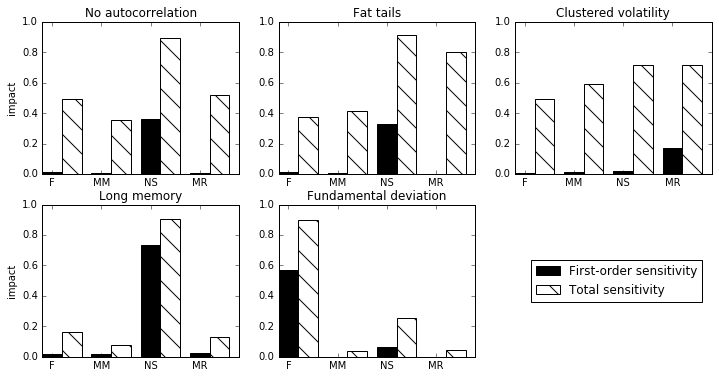

In [90]:
# plot 5 histograms 
#fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12,5))
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

N = 4
ind = np.arange(N)  # the x locations for the groups
width = 0.40       # the width of the bars

ax1 = axes[0,0] 
ax2 = axes[0,1]
ax3 = axes[0,2]
ax4 = axes[1,0]
ax5 = axes[1,1]

ax1.set_title('No autocorrelation')
rects1 = ax1.bar(ind, impact_on_no_a['S1'], width, color='k')
rects2 = ax1.bar(ind + width, impact_on_no_a['ST'], width, color='w', hatch='\\')
#ax1.legend((rects1[0], rects2[0]), ('S1', 'ST'))
ax1.set_ylabel('impact')

ax2.set_title('Fat tails')
rects3 = ax2.bar(ind, impact_on_f_t['S1'], width, color='k')
rects4 = ax2.bar(ind + width, impact_on_f_t['ST'], width, color='w', hatch='\\')

ax3.set_title('Clustered volatility')
rects5 = ax3.bar(ind, impact_on_cv['S1'], width, color='k')
rects6 = ax3.bar(ind + width, impact_on_cv['ST'], width, color='w', hatch='\\')

ax4.set_title('Long memory')
rects7 = ax4.bar(ind, impact_on_lm['S1'], width, color='k')
rects8 = ax4.bar(ind + width, impact_on_lm['ST'], width, color='w', hatch='\\')
ax4.set_ylabel('impact')

ax5.set_title('Fundamental deviation')
rects9 = ax5.bar(ind, impact_on_df['S1'], width, color='k')
rects10 = ax5.bar(ind + width, impact_on_df['ST'], width, color='w', hatch='\\')
ax5.legend((rects9[0], rects10[0]), ('First-order sensitivity', 'Total sensitivity'), 
           loc='center left', bbox_to_anchor=(1.25, 0.5))

axes[1, 2].remove()

for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('F', 'MM', 'NS', 'MR'))
    ax.set_ylim(0, 1.0)
    
fig.savefig('eFastExpectations.png')